In [1]:
from __future__ import division
import argparse
import tensorflow as tf
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

print(tf.VERSION)
print(tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from PIL import Image
import os
from glob import glob
import seaborn as sns
import cv2
from keras.utils.np_utils import to_categorical 
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout,Activation, Flatten, Conv2D, MaxPool2D,AveragePooling3D,Reshape, LSTM,ConvLSTM2D, TimeDistributed
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical 

from sklearn.model_selection import train_test_split


from ipynb.fs.full.Creating_Labels_Fn import read_images1, read_images2,labels_quick,labels_quick_order, create_image_data,create_image_data_order, breakdown, create_subset,create_subset_order,subplots, combine, normalize, plots1, plots2

import re

1.14.0
2.2.4-tf


Using TensorFlow backend.
W0823 13:14:09.506460 139638947964736 deprecation_wrapper.py:119] From /home/clk3/Datasets/Multi class weather dataset/Python/Creating_Labels_Fn.ipynb:16: The name tf.VERSION is deprecated. Please use tf.version.VERSION instead.



1.14.0
2.2.4-tf


This notebook focuses on a LSTM framework for the RobotCar Oxford driving set. It starts with a small portion of that dataset and will eventually incorporate a bigger element. 4 classes were considered, seeing if it were possible to categorize the weather displayed in the images by incorporating a time element.

In [2]:
classes_final = ["cloudy",  "shine","rain", "snow"]

# 1) Read in Images + Label

In [3]:
test_dir = '/home/clk3/Datasets/RobotCar_Altered'

imageid_path_dict1 = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(test_dir,"*", '*.png'))}

**Need to reorder data by reversing dictionary:**

In [4]:
list_keys = [ k for k in imageid_path_dict1 ]

In [5]:
imageid_path_dict2 = {imageid_path_dict1[k]: k for k in list_keys}
imageid_path_dict = {imageid_path_dict2[k]:k for k in imageid_path_dict2}

In [6]:
class_dict = read_images2(imageid_path_dict, classes_final)

In [7]:
labels_num, labels_list =labels_quick_order(imageid_path_dict , class_dict, classes_final)

(45338, 1)


In [8]:
breakdown(labels_list, classes_final)

cloudy : 12002 0.265
shine : 9333 0.206
rain : 12002 0.265
snow : 12001 0.265
45338


In [9]:
labels_num.shape[0]

45338

Trying to create batches now before having to create image arrays since computer seems to be unable to process

**Now going to segment the images and associated labels into subgroups of 5 ordered images:**

In [10]:
limit = [12000,9330,12000,12000] # for each label, the total number of images we wish to keep
subset,labels_num_subset, labels_list_subset, class_subset = create_subset_order(imageid_path_dict, class_dict, classes_final, limit)

(45330, 1)


In [11]:
n = labels_num_subset.shape[0]
L = 5
list_id = []
for x in sorted(subset):
    list_id.append(x)
    
X_bunch = [] #grouping the image id's in batches of L
Y_bunch = [] #grouping the image label's in batches of L
for k in range(n - L + 1):
    if labels_num_subset[k]==labels_num_subset[k+1]==labels_num_subset[k+2]==labels_num_subset[k+3]==labels_num_subset[k+4]:
        X_bunch.append(list_id[k : k + L])
        Y_bunch.append(labels_num_subset[k : k + L])
    

X_bunch = np.array(X_bunch)
Y_bunch = np.array(Y_bunch)

In [12]:
X_bunch.shape

(45310, 5)

Need to choose a further subset since the GPU's won't be able to process this amount of images, and want to ensure they are randomised within their categories as well:

In [24]:
subset_bunch,  other ,label_bunch, other_label= train_test_split(X_bunch, Y_bunch, test_size=(24/25), random_state = 2000)

In [25]:
subset_bunch.shape

(1812, 5)

**Want to have the labels associated with the bunches :**

In [26]:
labels_list_subset_bunch = [] 
for k in range(len(label_bunch)): 
    for y in range(len(classes_final)):
        if label_bunch[k,0].tolist()[0] == y:
            labels_list_subset_bunch.append(classes_final[y])
            break

In [27]:
breakdown(labels_list_subset_bunch, classes_final)

cloudy : 492 0.272
shine : 363 0.2
rain : 477 0.263
snow : 480 0.265
1812


**Need to create image data**

In [28]:
L=5 
data_a = []
for x in range(len(subset_bunch)):
    nimgb = []
    for i in range(5):
        oimg = cv2.imread(subset[subset_bunch[x,i]])[...,::-1]
        nimg = cv2.resize(oimg,(100,75))
        nimgb.append(nimg)
    
    data_a.append(nimgb)
data = np.asarray(data_a)

In [29]:
data.shape

(1812, 5, 75, 100, 3)

**Subplots 1 - First Image taken from each batch sample**

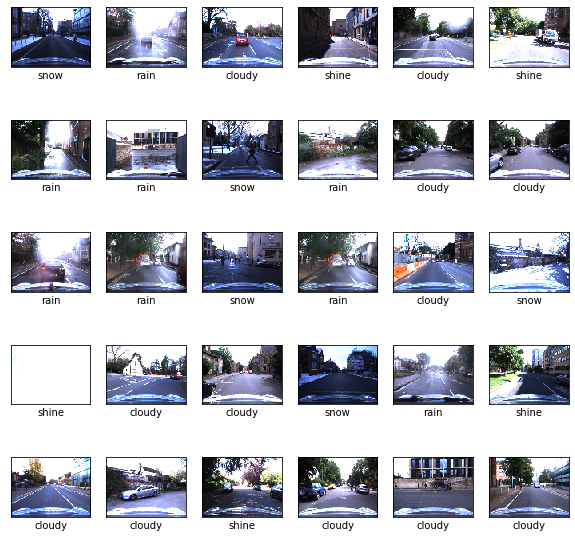

In [30]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[i,0], cmap=plt.cm.binary)
    plt.xlabel(labels_list_subset_bunch[i])

In [31]:
dict1 = {"cloudy":"Cloudy", "shine":"Shine", "rain":"Rain", "snow":"Snow"}

**Subplots 2 - Each row showcases one batch of five ordered images of the same category**

In [32]:
font = {'family': 'serif',
        'size': 12,
        }

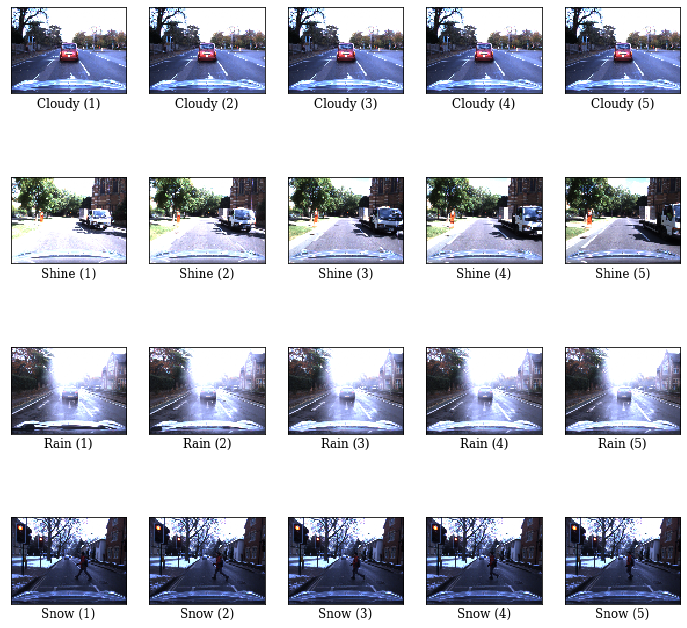

In [33]:
plt.figure(figsize=(12,12))
k=0
for i in [2,5,1,8]:
    for j in range(5):
        plt.subplot(4,5,k+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data[i,j], cmap=plt.cm.binary)
        plt.xlabel(dict1[labels_list_subset_bunch[i]] + " " + "("+str(j+1)+")", fontdict = font)
        k+=1

# Model Building

In [36]:
data.shape

(1812, 5, 75, 100, 3)

In [37]:
label_bunch.shape

(1812, 5, 1)

Splitting up into the training, test and validation sets:

In [38]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(data, label_bunch, test_size=0.20,random_state=5604)

In [39]:
x_train, x_val, y_train, y_val = train_test_split(x_train_o, y_train_o, test_size = 0.1, random_state = 50)

First will run with batch sizes of 5, then will choose one model of these 5. Will then re try that model with batch sizes of 3 and 10. 

**Model 1**

In [136]:
model_1 = keras.Sequential([
    keras.layers.ConvLSTM2D(32,kernel_size=(3,3), input_shape=data.shape[1:], return_sequences=True),
    keras.layers.AveragePooling3D((1, 73, 98)),
    keras.layers.Reshape((-1, 32)),
    keras.layers.Dense(4, activation=tf.nn.softmax)
])
model_1.summary()

model_1.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_5 (ConvLSTM2D)  (None, 5, 73, 98, 32)     40448     
_________________________________________________________________
average_pooling3d_4 (Average (None, 5, 1, 1, 32)       0         
_________________________________________________________________
reshape_4 (Reshape)          (None, None, 32)          0         
_________________________________________________________________
dense_7 (Dense)              (None, None, 4)           132       
Total params: 40,580
Trainable params: 40,580
Non-trainable params: 0
_________________________________________________________________


In [137]:
%%time
history = model_1.fit(x_train, y_train, epochs=10, batch_size=5,validation_data=(x_val, y_val), verbose=1)

Train on 1304 samples, validate on 145 samples
Epoch 1/10
1304/1304 [==============================] - 178s 136ms/sample - loss: 1.0905 - acc: 0.5132 - val_loss: 0.8800 - val_acc: 0.6414
Epoch 2/10
1304/1304 [==============================] - 179s 137ms/sample - loss: 0.8842 - acc: 0.5860 - val_loss: 0.7943 - val_acc: 0.6538
Epoch 3/10
1304/1304 [==============================] - 177s 135ms/sample - loss: 0.8316 - acc: 0.6135 - val_loss: 0.7717 - val_acc: 0.6276
Epoch 4/10
1304/1304 [==============================] - 177s 136ms/sample - loss: 0.8101 - acc: 0.6141 - val_loss: 0.7545 - val_acc: 0.6455
Epoch 5/10
1304/1304 [==============================] - 182s 140ms/sample - loss: 0.8048 - acc: 0.6235 - val_loss: 0.7572 - val_acc: 0.6290
Epoch 6/10
1304/1304 [==============================] - 178s 137ms/sample - loss: 0.7799 - acc: 0.6360 - val_loss: 0.7562 - val_acc: 0.6124
Epoch 7/10
1304/1304 [==============================] - 177s 136ms/sample - loss: 0.7583 - acc: 0.6526 - val_loss

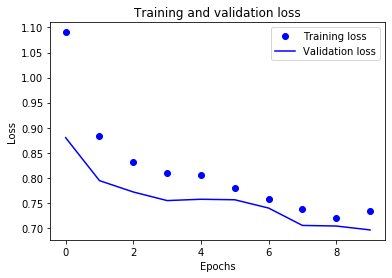

In [138]:
plots1(history)

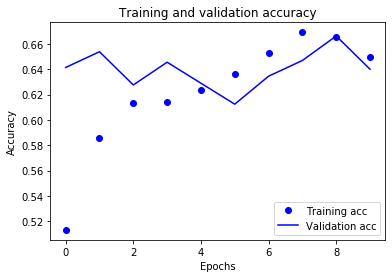

In [139]:
plots2(history)

In [140]:
model_1.evaluate(x_test_o, y_test_o)

363/363 [==============================] - 10s 28ms/sample - loss: 0.7158 - acc: 0.6590


[0.7158196634169124, 0.6589532]

**Model 2 Try another Convolutional layer:**

In [141]:
model_2 = keras.Sequential([
    keras.layers.ConvLSTM2D(32,kernel_size=(3,3), input_shape=data.shape[1:], return_sequences=True),
    #keras.layers.Flatten(),
    keras.layers.ConvLSTM2D(32,kernel_size=(3,3), return_sequences=True),
    keras.layers.AveragePooling3D((1, 71, 96)),
    keras.layers.Reshape((-1, 32)),
    #keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.softmax)
])
model_2.summary()

model_2.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_6 (ConvLSTM2D)  (None, 5, 73, 98, 32)     40448     
_________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)  (None, 5, 71, 96, 32)     73856     
_________________________________________________________________
average_pooling3d_5 (Average (None, 5, 1, 1, 32)       0         
_________________________________________________________________
reshape_5 (Reshape)          (None, None, 32)          0         
_________________________________________________________________
dense_8 (Dense)              (None, None, 4)           132       
Total params: 114,436
Trainable params: 114,436
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model_2.fit(x_train, y_train, epochs=10, batch_size=5,validation_data=(x_val, y_val), verbose=1)

Train on 1305 samples, validate on 145 samples
Epoch 1/5
1305/1305 [==============================] - 444s 340ms/sample - loss: 0.9562 - acc: 0.5457 - val_loss: 0.7161 - val_acc: 0.6786
Epoch 2/5
1305/1305 [==============================] - 443s 339ms/sample - loss: 0.7582 - acc: 0.6544 - val_loss: 0.5929 - val_acc: 0.7697
Epoch 3/5
1305/1305 [==============================] - 444s 340ms/sample - loss: 0.7055 - acc: 0.6746 - val_loss: 0.7019 - val_acc: 0.6428
Epoch 4/5
1305/1305 [==============================] - 450s 345ms/sample - loss: 0.6549 - acc: 0.7065 - val_loss: 0.5611 - val_acc: 0.7545
Epoch 5/5
1305/1305 [==============================] - 443s 340ms/sample - loss: 0.6362 - acc: 0.7050 - val_loss: 0.4747 - val_acc: 0.8014


In [30]:
model_2.evaluate(x_test_o, y_test_o)

363/363 [==============================] - 21s 59ms/sample - loss: 0.5270 - acc: 0.7846


[0.5269986806493817, 0.784573]

**2**

In [47]:
%%time
history = model_2.fit(x_train, y_train, epochs=10, batch_size=5,validation_data=(x_val, y_val), verbose=1)

Train on 1087 samples, validate on 121 samples
Epoch 1/10
1087/1087 [==============================] - 372s 342ms/sample - loss: 0.9437 - acc: 0.5496 - val_loss: 0.7398 - val_acc: 0.6132
Epoch 2/10
1087/1087 [==============================] - 368s 338ms/sample - loss: 0.7795 - acc: 0.6383 - val_loss: 0.6780 - val_acc: 0.7190
Epoch 3/10
1087/1087 [==============================] - 368s 338ms/sample - loss: 0.7237 - acc: 0.6607 - val_loss: 0.8453 - val_acc: 0.6000
Epoch 4/10
1087/1087 [==============================] - 368s 338ms/sample - loss: 0.6753 - acc: 0.6933 - val_loss: 0.7623 - val_acc: 0.6331
Epoch 5/10
1087/1087 [==============================] - 369s 340ms/sample - loss: 0.6586 - acc: 0.6966 - val_loss: 0.6220 - val_acc: 0.7372
Epoch 6/10
1087/1087 [==============================] - 369s 339ms/sample - loss: 0.7292 - acc: 0.6655 - val_loss: 0.6117 - val_acc: 0.6860
Epoch 7/10
1087/1087 [==============================] - 369s 339ms/sample - loss: 0.6518 - acc: 0.7056 - val_loss

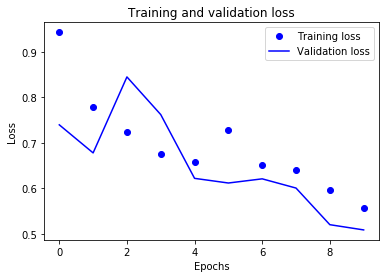

In [51]:
plots1(history)

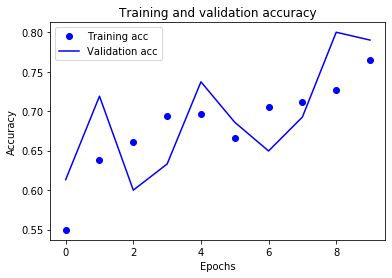

In [52]:
plots2(history)

In [48]:
model_2.evaluate(x_test_o, y_test_o)

303/303 [==============================] - 18s 59ms/sample - loss: 0.5392 - acc: 0.7861


[0.5391931506273376, 0.7861386]

**3**

In [142]:
%%time
history2 = model_2.fit(x_train, y_train, epochs=10, batch_size=5,validation_data=(x_val, y_val), verbose=1)

Train on 1304 samples, validate on 145 samples
Epoch 1/10
1304/1304 [==============================] - 443s 339ms/sample - loss: 0.9673 - acc: 0.5284 - val_loss: 0.7705 - val_acc: 0.6166
Epoch 2/10
1304/1304 [==============================] - 443s 340ms/sample - loss: 0.7515 - acc: 0.6293 - val_loss: 0.7673 - val_acc: 0.5738
Epoch 3/10
1304/1304 [==============================] - 442s 339ms/sample - loss: 0.7423 - acc: 0.6388 - val_loss: 0.7420 - val_acc: 0.6400
Epoch 4/10
1304/1304 [==============================] - 443s 340ms/sample - loss: 0.6783 - acc: 0.6972 - val_loss: 0.6511 - val_acc: 0.6952
Epoch 5/10
1304/1304 [==============================] - 443s 340ms/sample - loss: 0.6782 - acc: 0.6983 - val_loss: 0.6423 - val_acc: 0.7172
Epoch 6/10
1304/1304 [==============================] - 443s 340ms/sample - loss: 0.6528 - acc: 0.7089 - val_loss: 0.5921 - val_acc: 0.7669
Epoch 7/10
1304/1304 [==============================] - 444s 340ms/sample - loss: 0.6161 - acc: 0.7238 - val_loss

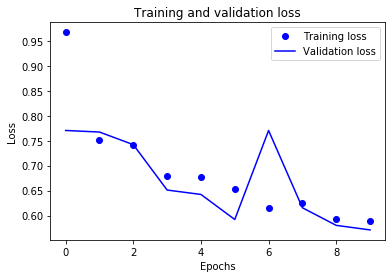

In [146]:
plots1(history2)

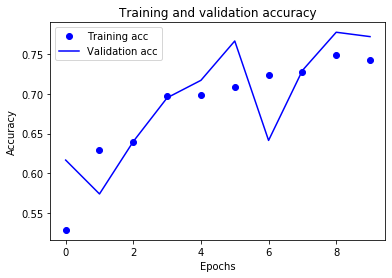

In [147]:
plots2(history2)

In [148]:
model_2.evaluate(x_test_o, y_test_o)

363/363 [==============================] - 21s 59ms/sample - loss: 0.5630 - acc: 0.7587


[0.5630478752217674, 0.75867766]

Add dropout layer and maybe another dense layer

**Model 3 - Small Dense Layer**

In [66]:
model_3 = keras.Sequential([
    keras.layers.ConvLSTM2D(32,kernel_size=(3,3), input_shape=data.shape[1:], return_sequences=True),
    keras.layers.AveragePooling3D((1, 73, 98)),
    keras.layers.Reshape((-1, 32)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.softmax)
])
model_3.summary()

model_3.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_4 (ConvLSTM2D)  (None, 5, 73, 98, 32)     40448     
_________________________________________________________________
average_pooling3d_2 (Average (None, 5, 1, 1, 32)       0         
_________________________________________________________________
reshape_2 (Reshape)          (None, None, 32)          0         
_________________________________________________________________
dense_6 (Dense)              (None, None, 32)          1056      
_________________________________________________________________
dense_7 (Dense)              (None, None, 4)           132       
Total params: 41,636
Trainable params: 41,636
Non-trainable params: 0
_________________________________________________________________


In [150]:
%%time
history3 = model_3.fit(x_train, y_train, epochs=10, batch_size=5,validation_data=(x_val, y_val), verbose=1)

Train on 1304 samples, validate on 145 samples
Epoch 1/10
1304/1304 [==============================] - 180s 138ms/sample - loss: 1.0728 - acc: 0.5113 - val_loss: 0.8413 - val_acc: 0.5724
Epoch 2/10
1304/1304 [==============================] - 177s 136ms/sample - loss: 0.8224 - acc: 0.5926 - val_loss: 0.7290 - val_acc: 0.6414
Epoch 3/10
1304/1304 [==============================] - 177s 136ms/sample - loss: 0.7657 - acc: 0.6391 - val_loss: 0.7759 - val_acc: 0.5338
Epoch 4/10
1304/1304 [==============================] - 177s 135ms/sample - loss: 0.7380 - acc: 0.6413 - val_loss: 0.7014 - val_acc: 0.6248
Epoch 5/10
1304/1304 [==============================] - 178s 137ms/sample - loss: 0.7153 - acc: 0.6555 - val_loss: 0.7452 - val_acc: 0.6621
Epoch 6/10
1304/1304 [==============================] - 177s 136ms/sample - loss: 0.6515 - acc: 0.6977 - val_loss: 0.6960 - val_acc: 0.6414
Epoch 7/10
1304/1304 [==============================] - 177s 136ms/sample - loss: 0.6576 - acc: 0.6822 - val_loss

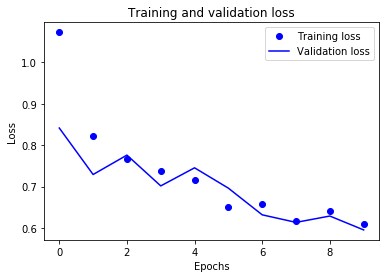

In [154]:
plots1(history3)

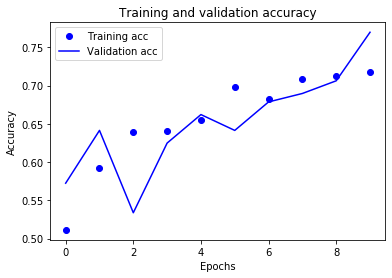

In [155]:
plots2(history3)

In [156]:
model_3.evaluate(x_test_o, y_test_o)

363/363 [==============================] - 10s 28ms/sample - loss: 0.5732 - acc: 0.7570


[0.5731598784115689, 0.75702477]

**2**

In [53]:
%%time
history3 = model_3.fit(x_train, y_train, epochs=10, batch_size=5,validation_data=(x_val, y_val), verbose=1)

Train on 1087 samples, validate on 121 samples
Epoch 1/10
1087/1087 [==============================] - 149s 137ms/sample - loss: 1.0577 - acc: 0.5286 - val_loss: 0.9271 - val_acc: 0.6132
Epoch 2/10
1087/1087 [==============================] - 148s 136ms/sample - loss: 0.8494 - acc: 0.5998 - val_loss: 0.7254 - val_acc: 0.6860
Epoch 3/10
1087/1087 [==============================] - 148s 136ms/sample - loss: 0.8191 - acc: 0.6086 - val_loss: 0.8648 - val_acc: 0.5802
Epoch 4/10
1087/1087 [==============================] - 148s 136ms/sample - loss: 0.7730 - acc: 0.6442 - val_loss: 0.7279 - val_acc: 0.6050
Epoch 5/10
1087/1087 [==============================] - 148s 136ms/sample - loss: 0.7212 - acc: 0.6567 - val_loss: 0.6435 - val_acc: 0.6777
Epoch 6/10
1087/1087 [==============================] - 148s 136ms/sample - loss: 0.6904 - acc: 0.6710 - val_loss: 0.6294 - val_acc: 0.6744
Epoch 7/10
1087/1087 [==============================] - 148s 136ms/sample - loss: 0.6761 - acc: 0.6914 - val_loss

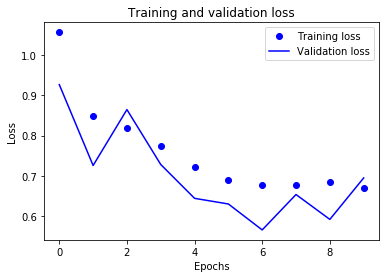

In [55]:
plots1(history3)

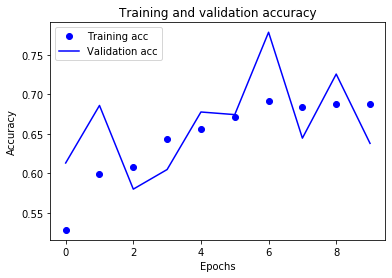

In [56]:
plots2(history3)

In [57]:
model_3.evaluate(x_test_o, y_test_o)

303/303 [==============================] - 9s 28ms/sample - loss: 0.6908 - acc: 0.6482


[0.6907679493671203, 0.64818484]

**Model 4 - Dropout layer + maybe another dense layer**

In [39]:
model_4 = keras.Sequential([
    keras.layers.ConvLSTM2D(32,kernel_size=(3,3), input_shape=data.shape[1:], return_sequences=True),
    keras.layers.AveragePooling3D((1, 73, 98)),
    keras.layers.Reshape((-1, 32)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.softmax)
])
model_4.summary()

model_4.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

W0820 20:56:35.737591 140639909439296 deprecation.py:506] From /home/clk3/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 5, 73, 98, 32)     40448     
_________________________________________________________________
average_pooling3d (AveragePo (None, 5, 1, 1, 32)       0         
_________________________________________________________________
reshape (Reshape)            (None, None, 32)          0         
_________________________________________________________________
dense (Dense)                (None, None, 32)          1056      
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 8)           264       
_________________________________________________________________
dense_2 (Dense)              (None, None, 4)           3

In [40]:
%%time
history4 = model_4.fit(x_train, y_train, epochs=10, batch_size=5,validation_data=(x_val, y_val), verbose=1)

Train on 1304 samples, validate on 145 samples


W0820 20:56:43.286446 140639909439296 deprecation.py:323] From /home/clk3/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
1304/1304 [==============================] - 181s 139ms/sample - loss: 1.0715 - acc: 0.4747 - val_loss: 0.9633 - val_acc: 0.4690
Epoch 2/10
1304/1304 [==============================] - 176s 135ms/sample - loss: 0.8616 - acc: 0.5629 - val_loss: 0.7809 - val_acc: 0.5931
Epoch 3/10
1304/1304 [==============================] - 176s 135ms/sample - loss: 0.8029 - acc: 0.5867 - val_loss: 0.7273 - val_acc: 0.6248
Epoch 4/10
1304/1304 [==============================] - 177s 136ms/sample - loss: 0.7719 - acc: 0.6152 - val_loss: 0.7744 - val_acc: 0.6055
Epoch 5/10
1304/1304 [==============================] - 177s 136ms/sample - loss: 0.7552 - acc: 0.6321 - val_loss: 0.6792 - val_acc: 0.6634
Epoch 6/10
1304/1304 [==============================] - 177s 136ms/sample - loss: 0.7207 - acc: 0.6511 - val_loss: 0.7043 - val_acc: 0.6828
Epoch 7/10
1304/1304 [==============================] - 177s 136ms/sample - loss: 0.7147 - acc: 0.6557 - val_loss: 0.6748 - val_acc: 0.6414
Epoch 8/10
1304/1304

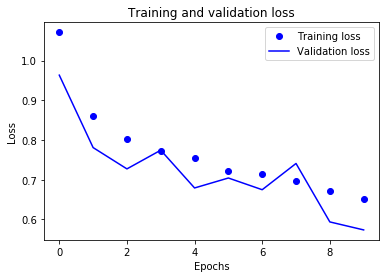

In [41]:
plots1(history4)

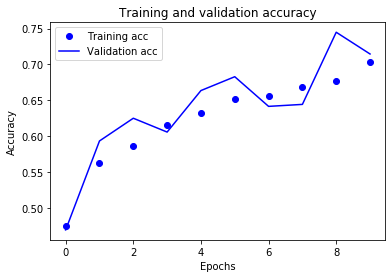

In [42]:
plots2(history4)

In [43]:
model_4.evaluate(x_test_o, y_test_o)

363/363 [==============================] - 12s 34ms/sample - loss: 0.5629 - acc: 0.7427


[0.5628650815690516, 0.74269974]

**Model 5 - 2 LSTM layers and a dense layer**

In [40]:
model_5 = keras.Sequential([
    keras.layers.ConvLSTM2D(32,kernel_size=(3,3), input_shape=data.shape[1:], return_sequences=True),
    keras.layers.ConvLSTM2D(32,kernel_size=(3,3), return_sequences=True),
    keras.layers.AveragePooling3D((1, 71, 96)),
    keras.layers.Reshape((-1, 32)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.softmax)
])
model_5.summary()

model_5.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 5, 73, 98, 32)     40448     
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 5, 71, 96, 32)     73856     
_________________________________________________________________
average_pooling3d_1 (Average (None, 5, 1, 1, 32)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, None, 32)          0         
_________________________________________________________________
dense_3 (Dense)              (None, None, 32)          1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense_4 (Dense)              (None, None, 8)          

In [41]:
%%time
history5 = model_5.fit(x_train, y_train, epochs=10, batch_size=5,validation_data=(x_val, y_val), verbose=1)

Train on 1304 samples, validate on 145 samples


W0821 10:40:12.724551 140291050985280 deprecation.py:323] From /home/clk3/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
1304/1304 [==============================] - 450s 345ms/sample - loss: 0.9537 - acc: 0.5167 - val_loss: 0.8139 - val_acc: 0.5517
Epoch 2/10
1304/1304 [==============================] - 449s 344ms/sample - loss: 0.8319 - acc: 0.5811 - val_loss: 0.8656 - val_acc: 0.5490
Epoch 3/10
1304/1304 [==============================] - 454s 348ms/sample - loss: 0.8240 - acc: 0.5799 - val_loss: 0.7367 - val_acc: 0.6193
Epoch 4/10
1304/1304 [==============================] - 453s 348ms/sample - loss: 0.7815 - acc: 0.6098 - val_loss: 0.7266 - val_acc: 0.6152
Epoch 5/10
1304/1304 [==============================] - -3073s -2356733us/sample - loss: 0.7577 - acc: 0.6160 - val_loss: 0.6994 - val_acc: 0.6897
Epoch 6/10
1304/1304 [==============================] - 452s 347ms/sample - loss: 0.7479 - acc: 0.6437 - val_loss: 0.6588 - val_acc: 0.7448
Epoch 7/10
1304/1304 [==============================] - 452s 346ms/sample - loss: 0.7379 - acc: 0.6414 - val_loss: 0.6611 - val_acc: 0.6621
Epoch 8/10
13

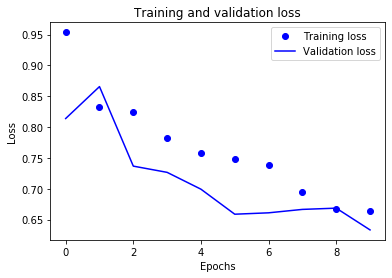

In [42]:
plots1(history5)

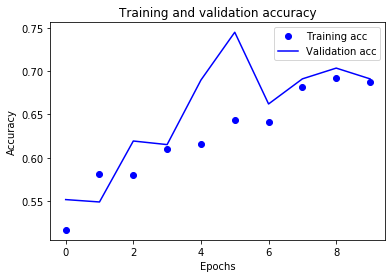

In [43]:
plots2(history5)

In [44]:
model_5.evaluate(x_test_o, y_test_o)

363/363 [==============================] - 23s 64ms/sample - loss: 0.5989 - acc: 0.7107


[0.5988971881630006, 0.7107438]

## Batch Size =3 Using Model 4?

In [10]:
limit = [12000,9330,12000,12000] # for each label, the total number of images we wish to keep
subset,labels_num_subset, labels_list_subset, class_subset = create_subset(imageid_path_dict, class_dict, classes_final, limit)

(45330, 1)


In [11]:
n = labels_num_subset.shape[0]
L = 3
list_id2 = []
for x in sorted(subset):
    list_id2.append(x)
    
X_bunch2 = [] #grouping the image id's in batches of L
Y_bunch2 = [] #grouping the image label's in batches of L
for k in range(n - L + 1):
    if labels_num_subset[k]==labels_num_subset[k+1]==labels_num_subset[k+2]:
        X_bunch2.append(list_id2[k : k + L])
        Y_bunch2.append(labels_num_subset[k : k + L])

X_bunch2 = np.array(X_bunch2)
Y_bunch2 = np.array(Y_bunch2)

In [12]:
X_bunch2.shape

(45322, 3)

In [23]:
subset_bunch2,  other ,label_bunch2, other_label= train_test_split(X_bunch2, Y_bunch2, test_size=(24/25), random_state = 2000)

In [24]:
labels_list_subset_bunch2 = [] 
for k in range(len(label_bunch2)): 
    for y in range(len(classes_final)):
        if label_bunch2[k,0].tolist()[0] == y:
            labels_list_subset_bunch2.append(classes_final[y])
            break

In [25]:
breakdown(labels_list_subset_bunch2, classes_final)

cloudy : 489 0.27
shine : 365 0.201
rain : 478 0.264
snow : 480 0.265
1812


In [26]:
 data_a = []
for x in range(len(subset_bunch2)):
    nimgb = []
    for i in range(L):
        oimg = cv2.imread(subset[subset_bunch2[x,i]])[...,::-1]
        nimg = cv2.resize(oimg,(100,75))
        nimgb.append(nimg)
    
    data_a.append(nimgb)
data2 = np.asarray(data_a)

In [27]:
data2.shape

(1812, 3, 75, 100, 3)

Splitting up into the training, test and validation sets:

In [28]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(data2, label_bunch2, test_size=0.20,random_state=5604)

In [29]:
x_train, x_val, y_train, y_val = train_test_split(x_train_o, y_train_o, test_size = 0.1, random_state = 50)

Whatever Model is chosen - 4

In [30]:
model_4 = keras.Sequential([
    keras.layers.ConvLSTM2D(32,kernel_size=(3,3), input_shape=data2.shape[1:], return_sequences=True),
    keras.layers.AveragePooling3D((1, 73, 98)),
    keras.layers.Reshape((-1, 32)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.softmax)
])
model_4.summary()

model_4.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

W0823 12:24:25.479070 139638947964736 deprecation.py:506] From /home/clk3/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 3, 73, 98, 32)     40448     
_________________________________________________________________
average_pooling3d (AveragePo (None, 3, 1, 1, 32)       0         
_________________________________________________________________
reshape (Reshape)            (None, None, 32)          0         
_________________________________________________________________
dense (Dense)                (None, None, 32)          1056      
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 8)           264       
_________________________________________________________________
dense_2 (Dense)              (None, None, 4)           3

In [31]:
%%time
history6 = model_4.fit(x_train, y_train, epochs=10, batch_size=L,validation_data=(x_val, y_val), verbose=1)

W0823 12:24:29.683395 139638947964736 deprecation.py:323] From /home/clk3/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1304 samples, validate on 145 samples
Epoch 1/10
1304/1304 [==============================] - 105s 81ms/sample - loss: 1.3084 - acc: 0.3142 - val_loss: 1.1351 - val_acc: 0.4253
Epoch 2/10
1304/1304 [==============================] - 104s 80ms/sample - loss: 1.0679 - acc: 0.4397 - val_loss: 1.2645 - val_acc: 0.3172
Epoch 3/10
1304/1304 [==============================] - 104s 80ms/sample - loss: 1.0599 - acc: 0.4642 - val_loss: 0.9468 - val_acc: 0.5747
Epoch 4/10
1304/1304 [==============================] - 104s 80ms/sample - loss: 1.0042 - acc: 0.4967 - val_loss: 0.9432 - val_acc: 0.4230
Epoch 5/10
1304/1304 [==============================] - 104s 80ms/sample - loss: 0.9621 - acc: 0.4997 - val_loss: 0.8862 - val_acc: 0.5310
Epoch 6/10
1304/1304 [==============================] - 104s 80ms/sample - loss: 0.9416 - acc: 0.5041 - val_loss: 0.8935 - val_acc: 0.4966
Epoch 7/10
1304/1304 [==============================] - 104s 80ms/sample - loss: 0.9295 - acc: 0.5133 - val_loss: 0.823

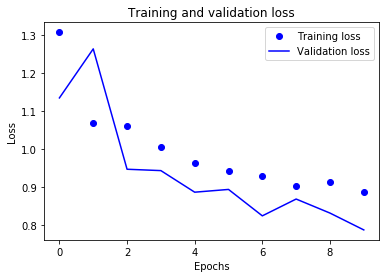

In [32]:
plots1(history6)

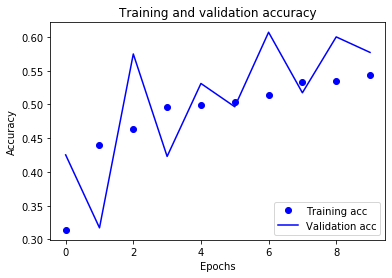

In [33]:
plots2(history6)

In [34]:
model_4.evaluate(x_test_o,y_test_o)

363/363 [==============================] - 6s 17ms/sample - loss: 0.8721 - acc: 0.5344


[0.8721158957678424, 0.5344353]

## Batch Size = 7

In [35]:
limit = [11998,9324,11998,11998] # for each label, the total number of images we wish to keep
subset2,labels_num_subset2, labels_list_subset2, class_subset2 = create_subset(imageid_path_dict, class_dict, classes_final, limit)

(45318, 1)


In [36]:
n = labels_num_subset2.shape[0]
L = 7
list_id3 = []
for x in sorted(subset2):
    list_id3.append(x)
    
X_bunch3 = [] #grouping the image id's in batches of L
Y_bunch3 = [] #grouping the image label's in batches of L
for k in range(n - L + 1):
    if labels_num_subset[k]==labels_num_subset[k+1]==labels_num_subset[k+2]==labels_num_subset[k+3]==labels_num_subset[k+4]==labels_num_subset[k+5]==labels_num_subset[k+6]:
        X_bunch3.append(list_id3[k : k + L])
        Y_bunch3.append(labels_num_subset2[k : k + L])

X_bunch3 = np.array(X_bunch3)
Y_bunch3 = np.array(Y_bunch3)

In [37]:
X_bunch3.shape

(45294, 7)

In [52]:
subset_bunch3,  other ,label_bunch3, other_label= train_test_split(X_bunch3, Y_bunch3, test_size=(24/25), random_state = 2000)

In [53]:
labels_list_subset_bunch3 = [] 
for k in range(len(label_bunch3)): 
    for y in range(len(classes_final)):
        if label_bunch3[k,0].tolist()[0] == y:
            labels_list_subset_bunch3.append(classes_final[y])
            break

In [54]:
breakdown(labels_list_subset_bunch3, classes_final)

cloudy : 490 0.271
shine : 365 0.202
rain : 477 0.263
snow : 479 0.264
1811


In [55]:
data_a = []
for x in range(len(subset_bunch3)):
    nimgb = []
    for i in range(L):
        oimg = cv2.imread(subset2[subset_bunch3[x,i]])[...,::-1]
        nimg = cv2.resize(oimg,(100,75))
        nimgb.append(nimg)
    
    data_a.append(nimgb)
data3 = np.asarray(data_a)

In [56]:
data3.shape

(1811, 7, 75, 100, 3)

Splitting up into the training, test and validation sets:

In [57]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(data3, label_bunch3, test_size=0.20,random_state=5604)

In [58]:
x_train, x_val, y_train, y_val = train_test_split(x_train_o, y_train_o, test_size = 0.1, random_state = 50)

Whatever Model is chosen - 4

In [60]:
model_4 = keras.Sequential([
    keras.layers.ConvLSTM2D(32,kernel_size=(3,3), input_shape=data3.shape[1:], return_sequences=True),
    keras.layers.AveragePooling3D((1, 73, 98)),
    keras.layers.Reshape((-1, 32)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.softmax)
])
model_4.summary()

model_4.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 7, 73, 98, 32)     40448     
_________________________________________________________________
average_pooling3d_1 (Average (None, 7, 1, 1, 32)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, None, 32)          0         
_________________________________________________________________
dense_3 (Dense)              (None, None, 32)          1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense_4 (Dense)              (None, None, 8)           264       
_________________________________________________________________
dense_5 (Dense)              (None, None, 4)          

In [61]:
history7 = model_4.fit(x_train, y_train, epochs=10, batch_size=L,validation_data=(x_val, y_val), verbose=1)

Train on 1303 samples, validate on 145 samples
Epoch 1/10
1303/1303 [==============================] - 254s 195ms/sample - loss: 1.3870 - acc: 0.2709 - val_loss: 1.3796 - val_acc: 0.2867
Epoch 2/10
1303/1303 [==============================] - 252s 194ms/sample - loss: 1.2338 - acc: 0.3823 - val_loss: 1.0623 - val_acc: 0.4473
Epoch 3/10
1303/1303 [==============================] - 252s 193ms/sample - loss: 1.0467 - acc: 0.4777 - val_loss: 1.0458 - val_acc: 0.4502
Epoch 4/10
1303/1303 [==============================] - 252s 193ms/sample - loss: 0.9895 - acc: 0.5265 - val_loss: 1.0886 - val_acc: 0.4138
Epoch 5/10
1303/1303 [==============================] - 251s 193ms/sample - loss: 0.9571 - acc: 0.5436 - val_loss: 0.9507 - val_acc: 0.5143
Epoch 6/10
1303/1303 [==============================] - 252s 193ms/sample - loss: 0.9352 - acc: 0.5579 - val_loss: 0.9470 - val_acc: 0.5458
Epoch 7/10
1303/1303 [==============================] - 252s 193ms/sample - loss: 0.9287 - acc: 0.5595 - val_loss

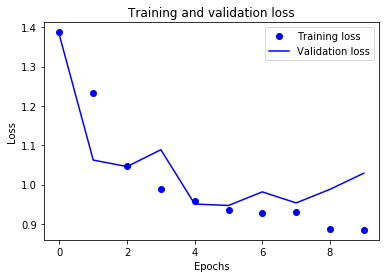

In [62]:
plots1(history7)

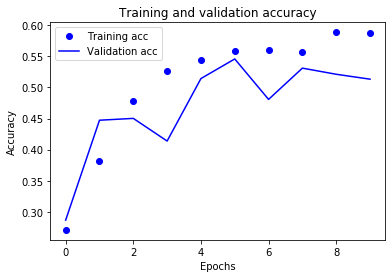

In [63]:
plots2(history7)

In [64]:
model_4.evaluate(x_test_o,y_test_o)

363/363 [==============================] - 14s 40ms/sample - loss: 0.9637 - acc: 0.5537


[0.9636893425106017, 0.553719]